In [1]:
import numpy as np
import matplotlib.pyplot as plt

import jax.numpy as jnp

In [2]:
def sample_w_state_binary(chain_length: int, num_samples: int, rng=None):
    if rng is None:
        rng = np.random.default_rng()

    chosen_spin_sites = rng.integers(low=0, high=chain_length, size=num_samples)

    samples = np.zeros((num_samples, chain_length), dtype=int)
    samples[np.arange(num_samples), chosen_spin_sites] = 1

    return samples


chain_length = 20
num_samples = 50_000
sample_rng = np.random.default_rng()

samples = sample_w_state_binary(chain_length, num_samples, rng=sample_rng)

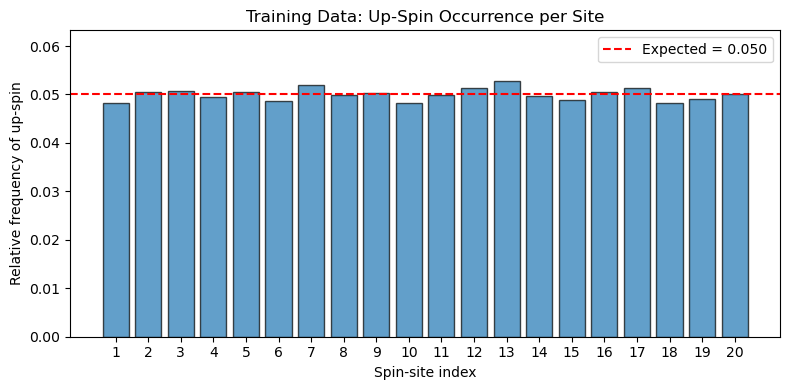

In [3]:
up_counts = np.array([sum(s[i] == 1 for s in samples) for i in range(chain_length)])
rel_freq  = up_counts / num_samples

fig, ax = plt.subplots(figsize=(8,4))
sites = np.arange(1, chain_length+1)
ax.bar(sites, rel_freq, width=0.8, edgecolor='black', alpha=0.7)
ax.axhline(1/chain_length, color='red', linestyle='--', label=f'Expected = {1/chain_length:.3f}')

ax.set_xlabel('Spin‐site index')
ax.set_ylabel('Relative frequency of up‐spin')
ax.set_title('Training Data: Up‐Spin Occurrence per Site')
ax.set_xticks(sites)
ax.set_ylim(0, rel_freq.max()*1.2)

ax.legend(loc='upper right')
plt.tight_layout()
plt.show()

In [4]:
file_name = f'w_vanilla_{chain_length}_meas_{num_samples}.txt'
file_path = file_name

with open(file_path, 'w') as f:
    for sample in samples:
        sample_str = ' '.join(map(str, sample))
        f.write(sample_str + '\n')

print(f"Wrote {len(samples)} samples to {file_path}")

Wrote 50000 samples to w_vanilla_20_meas_50000.txt


In [7]:
#### VANILLA W STATE
rng_seed = 42
num_qubits = chain_length
state_dim = 1 << num_qubits  # 2**num_qubits

# Indices corresponding to basis states with one '1' at position i (big-endian)
one_hot_indices = 1 << jnp.arange(num_qubits - 1, -1, -1)

# All amplitudes equal and real for vanilla W state
amplitude = 1 / jnp.sqrt(num_qubits)
one_hot_amplitudes = jnp.full((num_qubits,), amplitude, dtype=jnp.complex64)

# Construct the full state vector
w_state = jnp.zeros(state_dim, dtype=jnp.complex64).at[one_hot_indices].set(one_hot_amplitudes)

# Display first few nonzero entries
print("First 10 amplitudes:")
nonzero_indices = jnp.nonzero(w_state)[0][:10]
for idx in nonzero_indices:
    print(f"{idx:0{num_qubits}b}: {w_state[idx]:.8f}")

print(f"\nSize of state vector in memory: {w_state.nbytes / (1024 ** 2):.2f} MB\n")

First 10 amplitudes:
00000000000000000001: 0.22360680+0.00000000j
00000000000000000010: 0.22360680+0.00000000j
00000000000000000100: 0.22360680+0.00000000j
00000000000000001000: 0.22360680+0.00000000j
00000000000000010000: 0.22360680+0.00000000j
00000000000000100000: 0.22360680+0.00000000j
00000000000001000000: 0.22360680+0.00000000j
00000000000010000000: 0.22360680+0.00000000j
00000000000100000000: 0.22360680+0.00000000j
00000000001000000000: 0.22360680+0.00000000j

Size of state vector in memory: 8.00 MB



In [8]:
def save_state_vector_columns(w_aug: jnp.ndarray, file_path: str):
    w_np = jnp.stack([jnp.real(w_aug), jnp.imag(w_aug)], axis=1)
    np.savetxt(file_path, np.array(w_np), fmt="%.10f")


file_path = f"w_vanilla_{chain_length}_state.txt"
save_state_vector_columns(w_state, file_path)